In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.2 MB/s eta 0:00:00


In [3]:
!pip install PyDrive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.4/987.4 kB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for PyDrive: filename=PyDrive-1.3.1-py3-none-any.whl size=27433 sha256=0591ef137caf8ed314eb385ff7545799d75bc25d5ede62c93c08c5f4ecd4c26d
  Stored in directory: /root/.cache/pip/wheels/6c/10/da/a5b513f5b3916fc391c20ee7b4633e5cf3396d570cdd74970f
Successfully built PyDrive


In [4]:
# General-purpose imports
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import quote
import webbrowser
import random
from collections import defaultdict
from base64 import b64decode

# Scikit-learn imports
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Imbalanced-learn imports
from imblearn.over_sampling import SMOTE

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    Input, LSTM, Attention, Embedding
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.applications import VGG16, ResNet50

# Kerastuner imports
from kerastuner.tuners import RandomSearch

# Google Colab imports
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Kaggle imports
import kagglehub

Epoch 1/40
2708/2708 ━━━━━━━━━━━━━━━━━━━━ 51s 17ms/step - accuracy: 0.4888 - loss: 1.1765 - val_accuracy: 0.7461 - val_loss: 0.6280 - learning_rate: 0.0010
Epoch 2/40
2708/2708 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - accuracy: 0.7684 - loss: 0.5757 - val_accuracy: 0.8257 - val_loss: 0.4174 - learning_rate: 0.0010
Epoch 3/40
2708/2708 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.8281 - loss: 0.4153 - val_accuracy: 0.8456 - val_loss: 0.3487 - learning_rate: 0.0010
Epoch 4/40
2708/2708 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.8463 - loss: 0.3563 - val_accuracy: 0.8510 - val_loss: 0.3427 - learning_rate: 0.0010
Epoch 5/40
2708/2708 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - accuracy: 0.8565 - loss: 0.3282 - val_accuracy: 0.8696 - val_loss: 0.2912 - learning_rate: 0.0010
Epoch 6/40
2708/2708 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - accuracy: 0.8633 - loss: 0.3107 - val_accuracy: 0.8651 - val_loss: 0.2841 - learning_rate: 0.0010
Epoch 7/40
2708/2708 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - accura

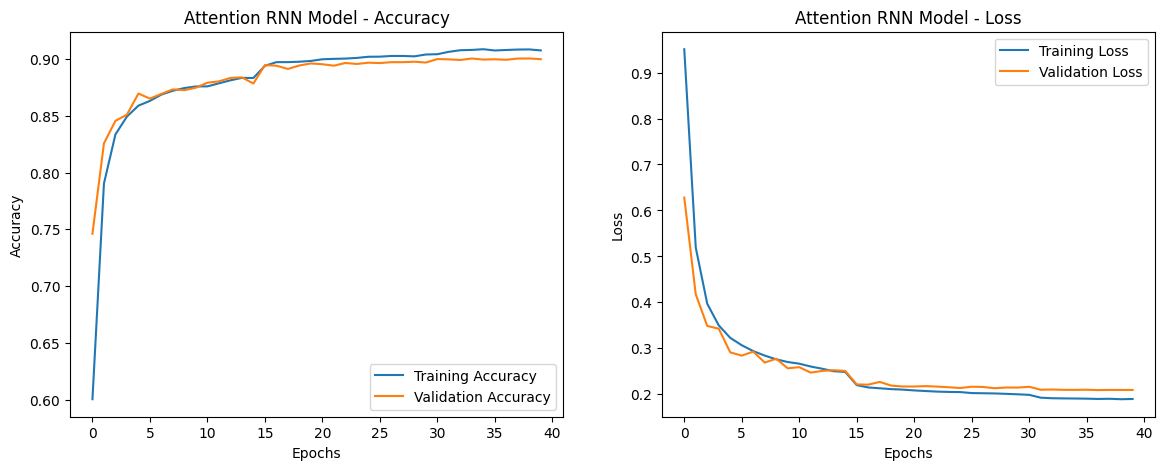

677/677 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

Classification Report for Attention RNN Model
              precision    recall  f1-score   support

       angry       0.94      0.99      0.96      4331
    surprise       0.94      0.98      0.96      4371
         sad       0.82      0.79      0.80      4375
       happy       0.84      0.76      0.80      4320
        fear       0.96      0.98      0.97      4264

    accuracy                           0.90     21661
   macro avg       0.90      0.90      0.90     21661
weighted avg       0.90      0.90      0.90     21661



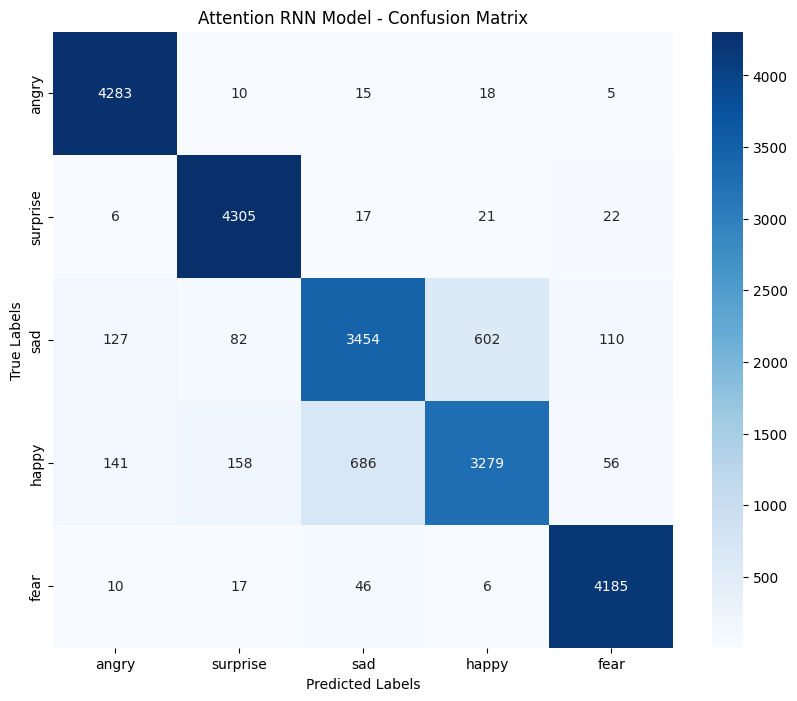

677/677 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


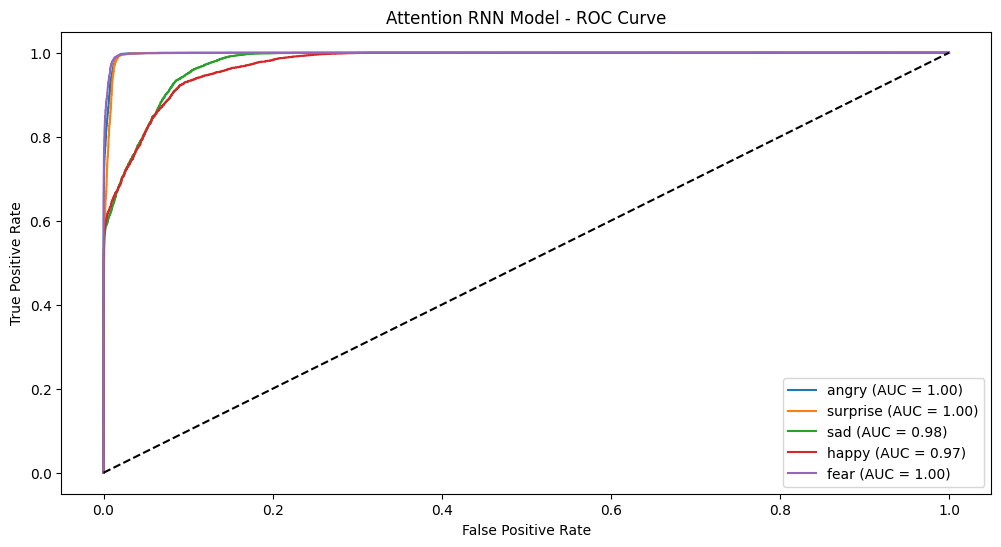

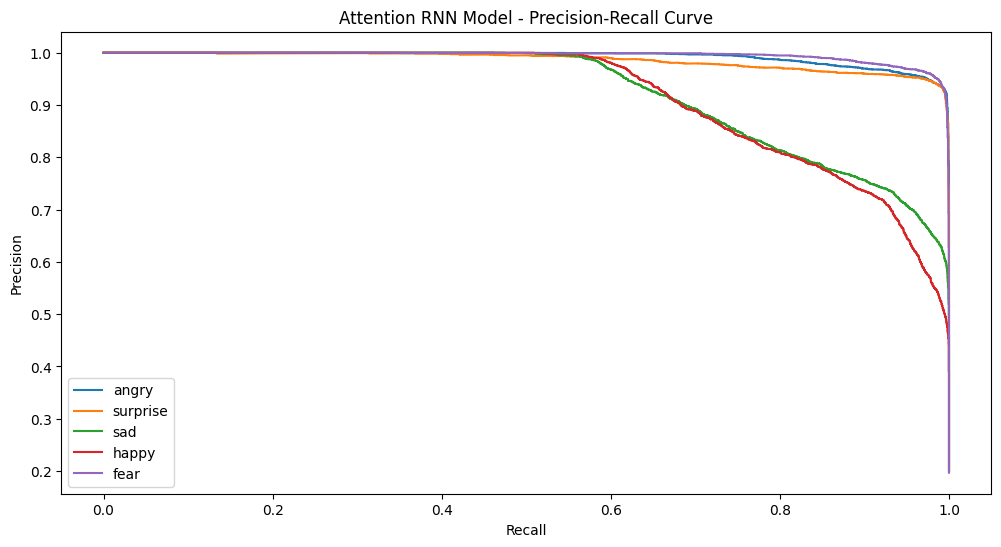

In [5]:
# Load Music Data
music_data_path = "/content/music_moods_dataset.csv"
music_data = pd.read_csv(music_data_path)

# ---------------------------- Configurations ---------------------------- #
IMAGE_SIZE = 48
BATCH_SIZE = 32
EPOCHS = 40

# ---------------------------- Selected Classes ---------------------------- #
SELECTED_MOODS = ['angry', 'surprise', 'sad', 'happy', 'fear']
SELECTED_CLASSES = ['angry', 'surprise', 'sad', 'happy', 'fear']

# ---------------------------- Music Data Preprocessing ---------------------------- #
def preprocess_music_data(music_data, selected_features, selected_moods):
    music_data = music_data[music_data['mood'].isin(selected_moods)]

    X_music = music_data[selected_features]
    y_music = music_data['mood']

    scaler = StandardScaler()
    X_music_scaled = scaler.fit_transform(X_music)

    encoder = OneHotEncoder(sparse_output=False)
    y_music_encoded = encoder.fit_transform(y_music.values.reshape(-1, 1))

    # Apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    X_music_balanced, y_music_balanced = smote.fit_resample(X_music_scaled, y_music_encoded)

    music_train_features, music_val_features, music_train_labels, music_val_labels = train_test_split(
        X_music_balanced, y_music_balanced, test_size=0.2, random_state=42
    )

    # Reshape for RNN compatibility
    music_train_features = music_train_features.reshape(-1, len(selected_features), 1)
    music_val_features = music_val_features.reshape(-1, len(selected_features), 1)

    return music_train_features, music_val_features, music_train_labels, music_val_labels

# ---------------------------- Attention-Based RNN for Music ---------------------------- #
def build_attention_rnn(input_shape, num_classes):
    """Build an Attention-Based RNN model."""
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(inputs)
    x = Attention()([x, x])
    x = LSTM(32)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# ---------------------------- Training and Evaluation ---------------------------- #
def train_and_evaluate_model(model, train_features, train_labels, val_features, val_labels):
    """Train and evaluate a model."""
    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
    ]

    history = model.fit(
        train_features, train_labels,
        validation_data=(val_features, val_labels),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks
    )

    score = model.evaluate(val_features, val_labels)
    print(f"Model Test Accuracy: {score[1] * 100:.2f}%")
    return history

# ---------------------------- Plotting Utilities ---------------------------- #
def plot_training_history(history, title):
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def plot_confusion_matrix_and_report(model, features, labels, selected_classes, title):
    """Plot confusion matrix and classification report for a model."""
    predictions = model.predict(features)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(labels, axis=1)

    # Classification Report
    print(f"\nClassification Report for {title}")
    print(classification_report(true_labels, predicted_labels, target_names=selected_classes))

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=selected_classes, yticklabels=selected_classes)
    plt.title(f"{title} - Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

def plot_roc_pr_curves(y_true, y_probs, selected_classes, model_name):
    """Plot ROC and Precision-Recall curves."""
    num_classes = y_true.shape[1]

    # ROC Curve
    plt.figure(figsize=(12, 6))
    for i, class_name in enumerate(selected_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"{model_name} - ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="best")
    plt.show()

    # Precision-Recall Curve
    plt.figure(figsize=(12, 6))
    for i, class_name in enumerate(selected_classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
        plt.plot(recall, precision, label=f'{class_name}')
    plt.title(f"{model_name} - Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="best")
    plt.show()

# ---------------------------- Execution Example ---------------------------- #
selected_features = [
    'danceability', 'energy', 'valence', 'tempo', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'loudness'
]

# Data Preparation
music_train_features, music_val_features, music_train_labels, music_val_labels = preprocess_music_data(
    music_data, selected_features, SELECTED_MOODS
)

# Attention RNN Model
rnn_model = build_attention_rnn((len(selected_features), 1), len(SELECTED_CLASSES))
rnn_history = train_and_evaluate_model(rnn_model, music_train_features, music_train_labels, music_val_features, music_val_labels)

# Plot Training History
plot_training_history(rnn_history, "Attention RNN Model")

# Evaluate Model with Confusion Matrix and Classification Report
plot_confusion_matrix_and_report(rnn_model, music_val_features, music_val_labels, SELECTED_CLASSES, "Attention RNN Model")

# ROC and Precision-Recall Curves
rnn_probs = rnn_model.predict(music_val_features)
plot_roc_pr_curves(music_val_labels, rnn_probs, SELECTED_CLASSES, "Attention RNN Model")